In [ ]:
# default_exp ds.prediction.eval.traceability

# Empirical Methods for Software Traceability: Prediction

> This module is dedicated to evaluate word2vec/doc2vec or any neural unsupervised approaches on traceability datasets by using the theory of information transmission.
> Implementing Predictive Analysis
> Author: @danaderp Feb 2021

Software Traceability is analyzed in three classes of tasks ways: description, prediction, and causal inference. 

## Prediction. 
### Predictive Analysis of Traceability Distance
In this section, we evaluate the effectiveness of traceability techniques. We employ metrics based on accuracy to evaluate the supervised software retrieval:
 - [1] Compute the average precision score and Compute ROC Curve
 - [2] Precision-Racall-Gain

### Predictive Analysis of Information Transmission
- Correlation of Entropy with Similarity
- Composable Manifolds of Entropy and Similarity

In this section, we evaluate the correlation between software transmission metrics and traceability distance metrics. 



In [ ]:
#export
from prg import prg

In [ ]:
#export
import ds4se as ds
from ds4se.mining.ir import VectorizationType
from ds4se.mining.ir import SimilarityMetric
from ds4se.mining.ir import EntropyMetric

In [ ]:
#export
#Description importation
from ds4se.ds.description.eval.traceability import VectorEvaluation

In [ ]:
#export
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
#export
import gensim
import pandas as pd
from itertools import product 
from random import sample 
import functools 
import os
from enum import Enum, unique, auto

In [ ]:
#export
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import auc
import math as m
import random as r
import collections
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [ ]:
#export
from scipy.spatial import distance
from scipy.stats import pearsonr

In [ ]:
#export
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
#export
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Loading Experiments

In [ ]:
#experiment 0.0.0/1
experiment = 'experiments0.0.x/'
path_data = '../dvc-ds4se/metrics/traceability/' + experiment 
def libest_params():
    return{
        "system": 'libest',
        "experiment_path_w2v": path_data + '[libest-VectorizationType.word2vec-LinkType.req2tc-True-1609292406.653621].csv',
        "experiment_path_d2v": path_data + '[libest-VectorizationType.doc2vec-LinkType.req2tc-True-1609289141.142806].csv',
        'saving_path': '../dvc-ds4se/se-benchmarking/traceability/testbeds/processed/',
        'system_long': 'libest',
        'timestamp': 1596063103.098236,
        'language': 'all-corpus'
    } 

In [ ]:
params = libest_params()
#params = sacp_params()

params['experiment_path_w2v']

'../dvc-ds4se/metrics/traceability/experiments0.0.x/[libest-VectorizationType.word2vec-LinkType.req2tc-True-1609292406.653621].csv'

In [ ]:
%matplotlib inline

#  Data Science Prediction Task
Prediction is using data to map some features of the world (the inputs) to other features of the world (the outputs). Prediction often starts with simple tasks (e.g., quantifying the association between albumin levels at admission and death within one week among patients in the intensive care unit) and then progresses to more complex ones (e.g., using hundreds of variables measured at admission to predict which patients are more likely to die within one week). The analytics employed for prediction range from elementary calculations (e.g., a correlation coefficient or a risk difference) to sophisticated pattern recognition methods and supervised learning algorithms that can be used as classifiers (e.g., random forests, neural networks) or to predict the joint distribution of multiple variables

In [ ]:
class SupervisedVectorEvaluation(VectorEvaluation):

    def __init__(self, params):
        super().__init__(params)
        
        self.sys = params['system']
        
        #Word2vec
        similarities_w2v = self.sim_list_w2v + ['Linked?']
        similarities_w2v = [str(i) for i in similarities_w2v]
        self.df_filtered_w2v = self.df_w2v.copy()
        self.df_filtered_w2v = self.df_filtered_w2v[similarities_w2v] 
        self.df_filtered_w2v = self.df_filtered_w2v[~self.df_filtered_w2v.isin([np.nan, np.inf, -np.inf]).any(1)]
        
        #Doc2vec
        similarities_d2v = self.sim_list_d2v + ['Linked?']
        similarities_d2v = [str(i) for i in similarities_d2v]
        self.df_filtered_d2v = self.df_d2v.copy() 
        self.df_filtered_d2v = self.df_filtered_d2v[similarities_d2v]
        self.df_filtered_d2v = self.df_filtered_d2v[~self.df_filtered_d2v.isin([np.nan, np.inf, -np.inf]).any(1)]
    
    def vecTypeVerification(self, vecType= VectorizationType.word2vec):
        if vecType == VectorizationType.word2vec:
            self.sim_list = self.sim_list_w2v
            y_test = self.df_filtered_w2v['Linked?'].values
            y_score = [self.df_filtered_w2v[ str(sim) ].values for sim in self.sim_list]
            logging.info('Vectorization: ' +  str(vecType) )
        elif vecType == VectorizationType.doc2vec:
            self.sim_list = self.sim_list_d2v
            y_test = self.df_filtered_d2v['Linked?'].values
            y_score = [self.df_filtered_d2v[ str(sim) ].values for sim in self.sim_list]
            logging.info('Vectorization: ' +  str(vecType) )
        return y_test,y_score
    
    def Compute_precision_recall_gain(self, vecType = VectorizationType.word2vec):
        '''One might choose PRG if there is little interest in identifying false negatives '''
        y_test,y_score = self.vecTypeVerification(vecType=vecType)    
        
        figures = []
        for count,sim in enumerate(self.sim_list):
            fig = plt.figure()
            prg_curve = prg.create_prg_curve(y_test, y_score[count])
            auprg = prg.calc_auprg(prg_curve)
            plot = prg.plot_prg(prg_curve)
            print(type(plot))
            logging.info('auprg:  %.3f' %  auprg)
            logging.info("compute_precision_recall_gain Complete: "+str(sim))
            figures.append(plot)
        return figures
    
    def Compute_avg_precision(self, vecType = VectorizationType.word2vec):
        '''Generated precision-recall curve enhanced'''
        y_test,y_score = self.vecTypeVerification(vecType=vecType)
        
        linestyles = ['solid','dashed','dashdot','dotted']
        
        fig, ax1 = plt.subplots(figsize=(8, 6))
        
        ax1.grid(True)
        #ax1.yaxis.grid(color='gray', linestyle='dashed')
        
        color = 'tab:red'
        ax1.set_xlabel('recall [fpr]')
        ax1.set_ylabel('precision', color=color)
        
        # calculate the no skill line as the proportion of the positive class
        no_skill = len(y_test[y_test==1]) / len(y_test)
        ax1.plot([0, 1], [no_skill, no_skill], color=color, linewidth=0.5, linestyle='dotted', label='No Skill [{0:0.2f}]'.format(no_skill)) #reference curve
        
        for count,sim in enumerate(self.sim_list):
            precision, recall, _ = precision_recall_curve(y_test, y_score[count]) #compute precision-recall curve
            average_precision = average_precision_score(y_test, y_score[count])
            auc_score = auc(recall, precision)
            logging.info('Average precision-recall score: {0:0.2f}'.format(average_precision))
            logging.info('Precision-Recall AUC: %.2f' % auc_score)
            
            #plt.plot(recall, precision, linewidth=0.4, marker='.', label = str(sim)) #plot model curve
            ax1.plot(recall, precision, color=color, linewidth=1, linestyle=linestyles[count], label = str(sim.name)+' [auc:{0:0.2f}]'.format(auc_score)) #plot model curve
                 
        
        ax1.tick_params(axis='y', labelcolor=color) #Color of the axis value
        
        
        ##AUC
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        
        color = 'tab:blue'
        ax2.set_ylabel('tpr', color=color)  # we already handled the x-label with ax1
        
        ax2.plot([0, 1], [0, 1], color=color,  linewidth=0.5, linestyle='dotted', label='No Skill') #reference curve
        for count,sim in enumerate(self.sim_list):
            fpr, tpr, _ = roc_curve(y_test, y_score[count]) #compute roc curve
            roc_auc = roc_auc_score(y_test, y_score[count])
            logging.info('ROC AUC %.2f' % roc_auc)
            
            ax2.plot(fpr, tpr, color=color, linewidth=1, linestyle=linestyles[count], label = str(sim.name)+ ' [auc:{0:0.2f}]'.format(roc_auc)) #plot model curve
               
        
        ax2.tick_params(axis='y', labelcolor=color) #Color of the axis value
        
        ##Design
        ax1.legend(loc='upper center',ncol=3, fontsize= 'small')
        ax2.legend(loc='lower center',ncol=3, fontsize= 'small')
        
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        
        #plt.set_axisbelow(True)
        #plt.yaxis.grid(color='gray', linestyle='dashed')
        
        plt.title( self.sys + "-[" + str(vecType) + "]")
        plt.plot()
        return fig
    
    def __Compute_avg_precision_same_plot(self, vecType = VectorizationType.word2vec):
        '''Generated precision-recall curve'''

        fig = plt.figure()
        y_test,y_score = self.vecTypeVerification(vecType=vecType)
        
        # calculate the no skill line as the proportion of the positive class
        no_skill = len(y_test[y_test==1]) / len(y_test)
        plt.plot([0, 1], [no_skill, no_skill], linewidth=0.5, linestyle='--', label='No Skill [{0:0.2f}]'.format(no_skill)) #reference curve
        
        for count,sim in enumerate(self.sim_list):
            precision, recall, _ = precision_recall_curve(y_test, y_score[count]) #compute precision-recall curve
            average_precision = average_precision_score(y_test, y_score[count])
            auc_score = auc(recall, precision)
            logging.info('Average precision-recall score: {0:0.2f}'.format(average_precision))
            logging.info('Precision-Recall AUC: %.2f' % auc_score)
            
            #plt.plot(recall, precision, linewidth=0.4, marker='.', label = str(sim)) #plot model curve
            plt.plot(recall, precision, linewidth=1, label = str(sim)+ ' [auc:{0:0.2f}]'.format(auc_score)) #plot model curve
            
        
        plt.title(str(vecType))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(fontsize=9) #show the legend
#         plt.show() #show the plot
        return fig
    
    def __Compute_roc_curve(self, vecType = VectorizationType.word2vec):
        
        fig = plt.figure()
        y_test,y_score = self.vecTypeVerification(vecType = vecType)

        plt.plot([0, 1], [0, 1],  linewidth=0.5, linestyle='--', label='No Skill') #reference curve
        
        for count,sim in enumerate(self.sim_list):
            fpr, tpr, _ = roc_curve(y_test, y_score[count]) #compute roc curve
            roc_auc = roc_auc_score(y_test, y_score[count])
            logging.info('ROC AUC %.2f' % roc_auc)
            
            plt.plot(fpr, tpr,  linewidth=1, label = str(sim)+  ' [auc:{0:0.2f}]'.format(roc_auc)) #plot model curve
            pass
        plt.title(str(vecType))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(fontsize=9) #show the legend
        #plt.show() #show the plot

        return figure
    
    def CofusionMatrix(self, vecType = VectorizationType.word2vec):
        ##TODO This implementatin is incomplete and not verify it yet
        y_test,y_score = self.vecTypeVerification(vecType=vecType)
        y_score_threshold = [0 if elem<=0.8 else 1 for elem in supevisedEval.y_score] #Hardcoded 0.7 Threshold
        #TODO a Variation threshold analysis
        tn, fp, fn, tp = confusion_matrix(supevisedEval.y_test, y_score_threshold).ravel()
        return tn, fp, fn, tp

In [ ]:
supevisedEval = SupervisedVectorEvaluation(params = params) #<---- Parameter 

In [ ]:
#tst
supevisedEval.df_w2v.head(2)

,Source,Target,DistanceMetric.WMD,SimilarityMetric.WMD_sim,DistanceMetric.SCM,SimilarityMetric.SCM_sim,EntropyMetric.MSI_I,EntropyMetric.MSI_X,EntropyMetric.Entropy_src,EntropyMetric.Entropy_tgt,EntropyMetric.JI,EntropyMetric.MI,EntropyMetric.Loss,EntropyMetric.Noise,Linked?
0,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us903.c,0.986586,0.503376,0.611706,0.388294,4.464656,1.390740,6.024675,8.626714,8.716142,5.935246,2.691468,0.089428,0.0
1,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us3496.c,0.990643,0.502350,0.642187,0.357813,4.228282,1.385062,6.024675,7.287890,7.522528,5.790037,1.497854,0.234638,0.0


In [ ]:
#tst
supevisedEval.df_d2v.head(2)

,Source,Target,DistanceMetric.EUC,SimilarityMetric.EUC_sim,DistanceMetric.COS,SimilarityMetric.COS_sim,DistanceMetric.MAN,SimilarityMetric.MAN_sim,SimilarityMetric.Pearson,Linked?
0,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us903.c,79.313499,0.012451,0.684047,0.315953,1422.18042,0.000703,0.315946,0.0
1,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us3496.c,81.898087,0.012063,0.752670,0.247330,1464.70813,0.000682,0.247231,0.0


In [ ]:
#tst
supevisedEval.df_filtered_w2v.size

3276

In [ ]:
#tst
supevisedEval.df_w2v.size

16380

In [ ]:
#tst
supevisedEval.df_w2v[ 'Linked?' ].values

array([0., 0., 0., ..., 0., 1., 1.])

In [ ]:
y_test,y_score = supevisedEval.vecTypeVerification(VectorizationType.word2vec) #tst

2021-03-29 16:18:54,537 : INFO : Vectorization: VectorizationType.word2vec


In [ ]:
y_test,y_score = supevisedEval.vecTypeVerification(VectorizationType.doc2vec) #tst

2021-03-29 16:18:54,710 : INFO : Vectorization: VectorizationType.doc2vec


## Traceability Distance Predictive Analysis

### 1. Compute the average precision score and Compute ROC Curve
Precision is a metric that quantifies the number of correct positive predictions made.

Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.

An ROC curve (or receiver operating characteristic curve) is a plot that summarizes the performance of a binary classification model on the positive class [(see Blog)](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/).

Use ROC when both classes detection is equally important — When we want to give equal weight to both classes prediction ability we should look at the ROC curve [link](https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba).

2021-03-29 16:18:55,232 : INFO : Vectorization: VectorizationType.word2vec
2021-03-29 16:18:55,249 : INFO : Average precision-recall score: 0.39
2021-03-29 16:18:55,250 : INFO : Precision-Recall AUC: 0.38
2021-03-29 16:18:55,251 : INFO : Average precision-recall score: 0.42
2021-03-29 16:18:55,251 : INFO : Precision-Recall AUC: 0.42
2021-03-29 16:18:55,262 : INFO : ROC AUC 0.57
2021-03-29 16:18:55,265 : INFO : ROC AUC 0.60


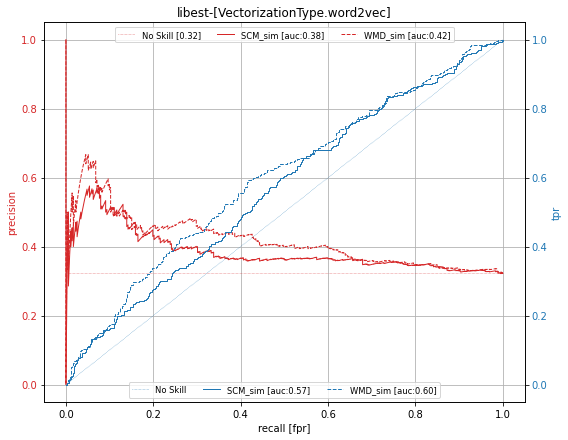

In [ ]:
f = supevisedEval.Compute_avg_precision(VectorizationType.word2vec)

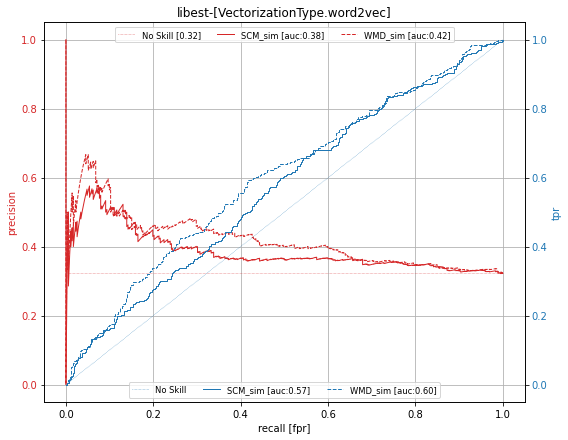

In [ ]:
f

2021-03-29 16:18:56,466 : INFO : Vectorization: VectorizationType.doc2vec
2021-03-29 16:18:56,480 : INFO : Average precision-recall score: 0.33
2021-03-29 16:18:56,480 : INFO : Precision-Recall AUC: 0.33
2021-03-29 16:18:56,483 : INFO : Average precision-recall score: 0.28
2021-03-29 16:18:56,484 : INFO : Precision-Recall AUC: 0.28
2021-03-29 16:18:56,502 : INFO : ROC AUC 0.51
2021-03-29 16:18:56,504 : INFO : ROC AUC 0.42


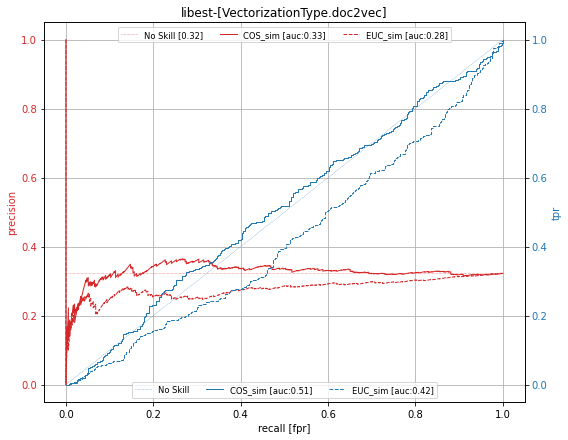

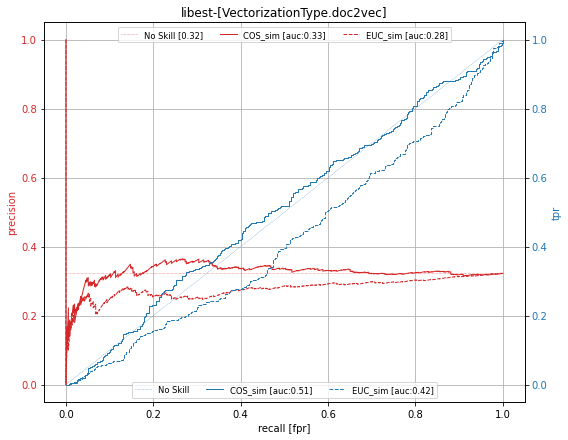

In [ ]:
supevisedEval.Compute_avg_precision(VectorizationType.doc2vec)

### 2. Precision-Racall-Gain
Based on the library here: [link](https://github.com/meeliskull/prg/tree/master/Python_package). 
The area under traditional PR curves can easily favour models with lower expected F1 score than others, and so the use of Precision-Recall-Gain curves will result in better model selection [(Flach & Kull, 2015)](http://people.cs.bris.ac.uk/~flach//PRGcurves/).
One might choose PRG if there is little interest in identifying false negatives [(from Blog)](https://medium.com/@alexabate/i-did-something-boring-so-you-dont-have-to-9140ca46c84d).

2021-03-29 16:18:57,277 : INFO : Vectorization: VectorizationType.word2vec


<Figure size 432x288 with 0 Axes>

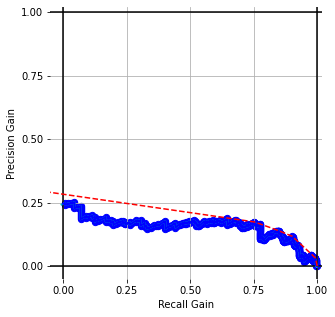

2021-03-29 16:18:57,364 : INFO : auprg:  0.156
2021-03-29 16:18:57,364 : INFO : compute_precision_recall_gain Complete: SimilarityMetric.SCM_sim


<class 'matplotlib.figure.Figure'>


<Figure size 432x288 with 0 Axes>

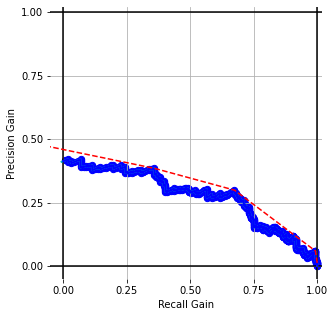

2021-03-29 16:18:57,435 : INFO : auprg:  0.278
2021-03-29 16:18:57,435 : INFO : compute_precision_recall_gain Complete: SimilarityMetric.WMD_sim


<class 'matplotlib.figure.Figure'>


In [ ]:
f = supevisedEval.Compute_precision_recall_gain(VectorizationType.word2vec)

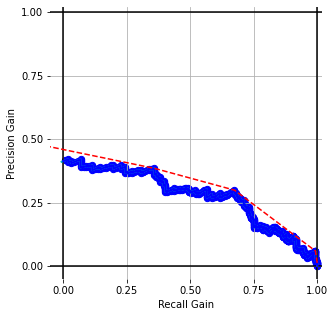

In [ ]:
f[1]

2021-03-29 16:18:57,783 : INFO : Vectorization: VectorizationType.doc2vec


<Figure size 432x288 with 0 Axes>

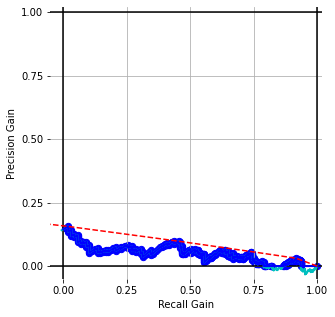

2021-03-29 16:18:57,875 : INFO : auprg:  0.050
2021-03-29 16:18:57,875 : INFO : compute_precision_recall_gain Complete: SimilarityMetric.COS_sim


<class 'matplotlib.figure.Figure'>


<Figure size 432x288 with 0 Axes>

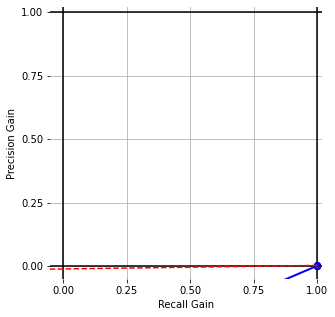

2021-03-29 16:18:57,946 : INFO : auprg:  -0.213
2021-03-29 16:18:57,946 : INFO : compute_precision_recall_gain Complete: SimilarityMetric.EUC_sim


<class 'matplotlib.figure.Figure'>


[<Figure size 432x360 with 1 Axes>, <Figure size 432x360 with 1 Axes>]

In [ ]:
supevisedEval.Compute_precision_recall_gain(VectorizationType.doc2vec)

In [ ]:
SimilarityMetric.WMD_sim.name #tst

'WMD_sim'

## Predictive Analysis of Information Transmission

### Correlation of Entropy with Similarity

In [ ]:
class ManifoldEntropy(VectorEvaluation):
    def __init__(self, params):
        super().__init__(params)
        self.sharedEntropy_filtered = self.sharedInfo.copy()
        self.sharedEntropy_filtered.dropna(inplace=True)
        self.sys = params['system']
    
    def minimum_shared_entropy(self,dist = SimilarityMetric.WMD_sim, extropy=False):
        '''Minimum Shared Plot'''
        ent = EntropyMetric.MSI_I
        color = 'DarkBlue'
        if extropy:
            ent = EntropyMetric.MSI_X
            color = 'Red'
        columns = [str(i) for i in [ent, dist ]]
        
        corr = self.compute_spearman_corr(self.sharedEntropy_filtered, columns)
        logging.info('Correlation {%.2f}' % corr)
        x1 = self.sharedEntropy_filtered.plot.scatter(
            x = columns[0],
            y = columns[1], 
            c = color, 
            s = 1,
            title = self.sys +': ['+ dist.name + '-' + ent.name + '] Correlation {%.2f}' % corr
        )
        return x1.figure
        
    
    def manifold_entropy_plot(self, manifold = EntropyMetric.MI, dist = SimilarityMetric.WMD_sim):
        '''Manifold Entropy'''
        
        columns = [str(i) for i in [manifold, dist]]
        corr = self.compute_spearman_corr(self.manifoldEntropy, columns)
        
        logging.info('Correlation {%.2f}' % corr)
        x1 = self.manifoldEntropy.plot.scatter(
            x = columns[0],
            y = columns[1], 
            c = 'DarkBlue', 
            s = 1,
            title = self.sys +': ['+ dist.name + '-' + manifold.name + '] Correlation {%.2f}' % corr
        )
        return x1.figure
    
    def composable_entropy_plot(self, 
                                manifold_x = EntropyMetric.MI,
                                manifold_y = EntropyMetric.Loss,
                                dist = SimilarityMetric.WMD_sim,
                                ground = False
                               ):
    
        columns = [str(i) for i in [manifold_x, manifold_y, dist]]
        fig, ax = plt.subplots()
        
        if ground:
            title = params['system']+': Information-Semantic Interactions by GT ' 
        else:
            title = params['system']+': Information-Semantic Interactions '+ dist.name
        
        self.manifoldEntropy.plot.scatter(
            x = columns[0],
            y = columns[1],
            c = columns[2],
            #figsize = [12, 6],
            title = title ,
            colormap = 'viridis',
            ax = ax,
            s=1
        )
        ax.set_xlabel( columns[0] )
        ax.set_ylabel( columns[1] )    
        return fig
    
    def composable_shared_plot(self, 
                                manifold_x = EntropyMetric.MSI_I,
                                manifold_y = EntropyMetric.Loss,
                                dist = SimilarityMetric.WMD_sim,
                                ground = False
                               ):
    
        columns = [str(i) for i in [manifold_x, manifold_y, dist]]
        fig, ax = plt.subplots()
        
        if ground:
            title = params['system']+': Information-Semantic Interactions by GT' 
        else:
            title = params['system']+': Information-Semantic Interactions '+ dist.name
        
        self.sharedEntropy_filtered.plot.scatter(
            x = columns[0],
            y = columns[1],
            c = columns[2],
            #figsize = [12, 6],
            title = title,
            colormap = 'viridis',
            ax = ax,
            s=1
        )
        ax.set_xlabel( columns[0] )
        ax.set_ylabel( columns[1] )    
        return fig
    
    def compute_spearman_corr(self, filter_metrics_01, columns):
        df_correlation = filter_metrics_01.copy() 
        correlation = df_correlation[columns].corr(method='spearman')
        #correlation = df_correlation.corr(method='spearman')
        return correlation[columns[0]].values[1]

In [ ]:
manifoldEntropy = ManifoldEntropy(params = params) 

In [ ]:
manifoldEntropy.sharedInfo.head()

,SimilarityMetric.SCM_sim,SimilarityMetric.WMD_sim,EntropyMetric.MSI_I,EntropyMetric.MSI_X,Linked?,SimilarityMetric.COS_sim,SimilarityMetric.EUC_sim
0,0.388294,0.503376,4.464656,1.390740,0.0,0.315953,0.012451
1,0.357813,0.502350,4.228282,1.385062,0.0,0.247330,0.012063
2,0.400631,0.505017,4.634286,1.398938,0.0,0.239200,0.009374
3,0.226293,0.489448,4.011289,1.368943,0.0,0.266594,0.011098
4,0.314296,0.498020,4.105223,1.381910,0.0,0.230731,0.010579


In [ ]:
manifoldEntropy.sharedEntropy_filtered.head(1)

,SimilarityMetric.SCM_sim,SimilarityMetric.WMD_sim,EntropyMetric.MSI_I,EntropyMetric.MSI_X,Linked?,SimilarityMetric.COS_sim,SimilarityMetric.EUC_sim
0,0.388294,0.503376,4.464656,1.39074,0.0,0.315953,0.012451


### Minimum Shared Entropy and Distances

Word Mover's Distance Correlations

2021-03-29 14:07:46,158 : INFO : Correlation {0.69}


<Figure size 432x288 with 0 Axes>

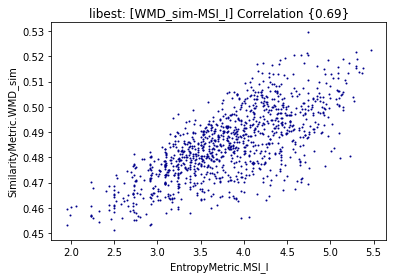

In [ ]:
f = manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.WMD_sim)

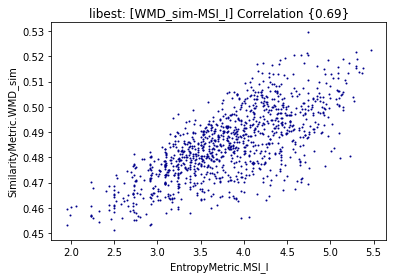

In [ ]:
f

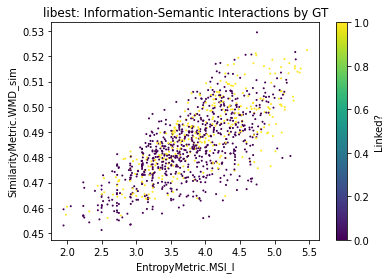

In [ ]:
#Correlations by GroundTruth
manifoldEntropy.composable_shared_plot(
                        manifold_x = EntropyMetric.MSI_I,
                        manifold_y = SimilarityMetric.WMD_sim,
                        dist = 'Linked?',
                        ground = True)

SoftCosine Similarity Correlations

2021-03-29 13:50:41,720 : INFO : Correlation {0.33}


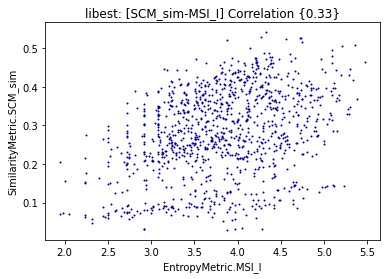

In [ ]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.SCM_sim)

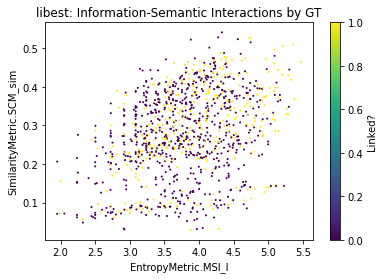

In [ ]:
#Correlations by GroundTruth
f = manifoldEntropy.composable_shared_plot(
                        manifold_x = EntropyMetric.MSI_I,
                        manifold_y = SimilarityMetric.SCM_sim,
                        dist = 'Linked?',
                        ground = True)

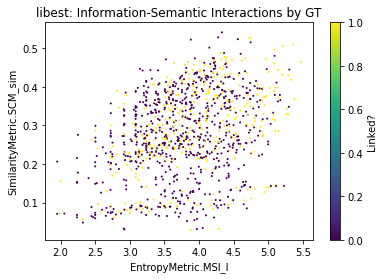

In [ ]:
f

Cosine Similarity Correlations

2021-03-29 13:50:41,920 : INFO : Correlation {0.41}


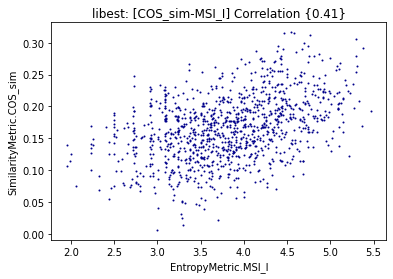

In [ ]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.COS_sim)

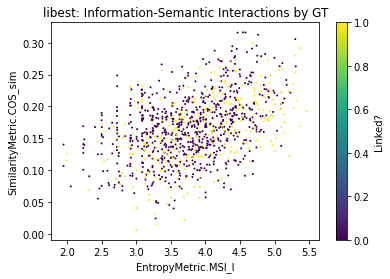

In [ ]:
#Correlations by GroundTruth
manifoldEntropy.composable_shared_plot(
                        manifold_x = EntropyMetric.MSI_I,
                        manifold_y = SimilarityMetric.COS_sim,
                        dist = 'Linked?',
                        ground = True)

Cosine Similarity Correlations

2021-03-29 13:50:42,117 : INFO : Correlation {-0.19}


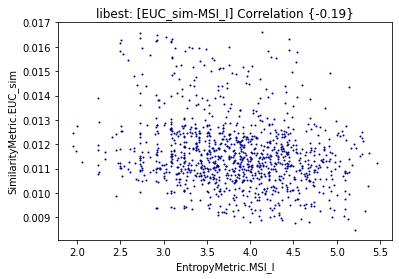

In [ ]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.EUC_sim)

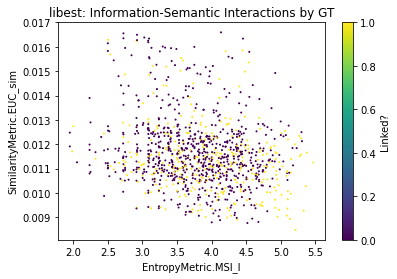

In [ ]:
#Correlations by GroundTruth
manifoldEntropy.composable_shared_plot(
                        manifold_x = EntropyMetric.MSI_I,
                        manifold_y = SimilarityMetric.EUC_sim,
                        dist = 'Linked?',
                        ground = True)

### Minimum Shared Extropy and Distances

2021-03-29 13:50:42,464 : INFO : Correlation {0.59}


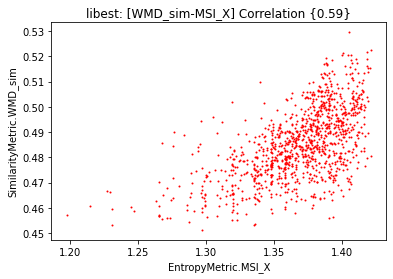

In [ ]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.WMD_sim, extropy=True)

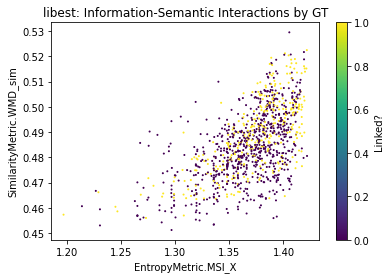

In [ ]:
#Correlations by GroundTruth
manifoldEntropy.composable_shared_plot(
                        manifold_x = EntropyMetric.MSI_X,
                        manifold_y = SimilarityMetric.WMD_sim,
                        dist = 'Linked?',
                        ground = True)

2021-03-29 13:50:42,676 : INFO : Correlation {0.27}


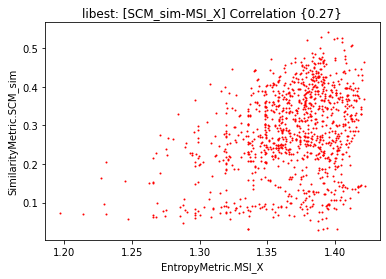

In [ ]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.SCM_sim, extropy=True)

2021-03-29 13:50:42,752 : INFO : Correlation {0.42}


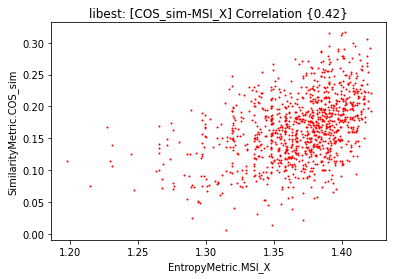

In [ ]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.COS_sim, extropy=True)

2021-03-29 13:50:42,832 : INFO : Correlation {-0.13}


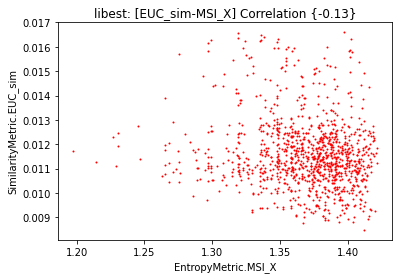

In [ ]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.EUC_sim, extropy=True)

### Mutual Information and Distance

WMD_sim

2021-03-29 13:50:42,920 : INFO : Correlation {0.44}


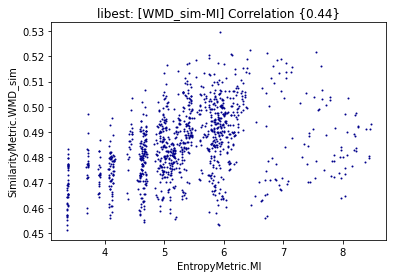

In [ ]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.MI, dist = SimilarityMetric.WMD_sim)

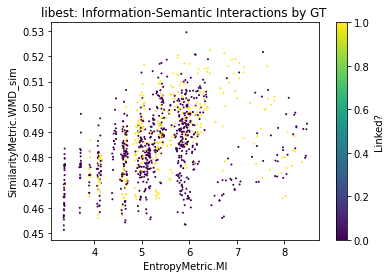

In [ ]:
#Correlations by GroundTruth
manifoldEntropy.composable_entropy_plot(
                        manifold_x = EntropyMetric.MI,
                        manifold_y = SimilarityMetric.WMD_sim,
                        dist = 'Linked?',
                        ground = True)

COS_sim

2021-03-29 13:50:43,131 : INFO : Correlation {0.28}


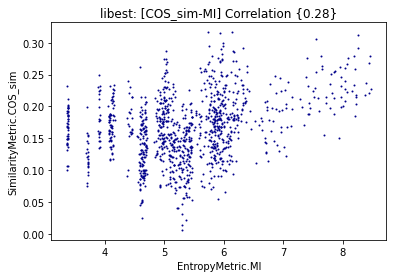

In [ ]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.MI, dist = SimilarityMetric.COS_sim)

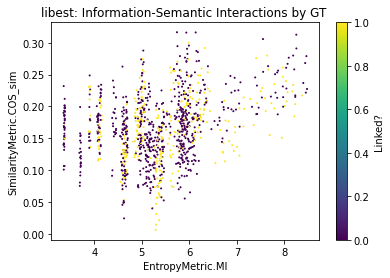

In [ ]:
#Correlations by GroundTruth
manifoldEntropy.composable_entropy_plot(
                        manifold_x = EntropyMetric.MI,
                        manifold_y = SimilarityMetric.COS_sim,
                        dist = 'Linked?',
                        ground = True)

### Loss Information and Distance

2021-03-29 13:50:43,328 : INFO : Correlation {-0.16}


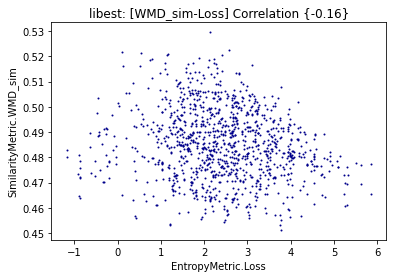

In [ ]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.Loss, dist = SimilarityMetric.WMD_sim)

2021-03-29 13:50:43,415 : INFO : Correlation {-0.13}


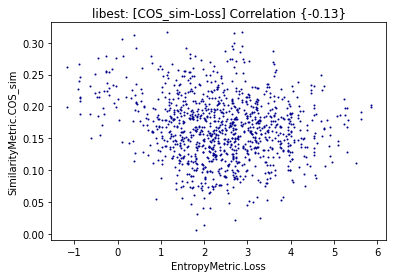

In [ ]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.Loss, dist = SimilarityMetric.COS_sim)

### Noise Information and Distance

2021-03-29 13:50:43,499 : INFO : Correlation {0.12}


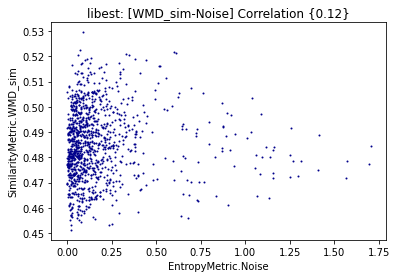

In [ ]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.Noise, dist = SimilarityMetric.WMD_sim)

2021-03-29 13:50:43,583 : INFO : Correlation {0.14}


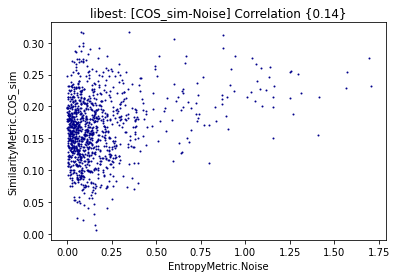

In [ ]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.Noise, dist = SimilarityMetric.COS_sim)

### Self-Information

2021-03-29 13:50:43,667 : INFO : Correlation {0.40}


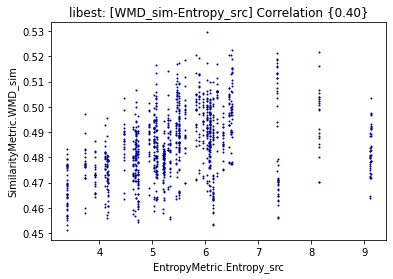

In [ ]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.Entropy_src, dist = SimilarityMetric.WMD_sim)

2021-03-29 13:50:43,750 : INFO : Correlation {0.34}


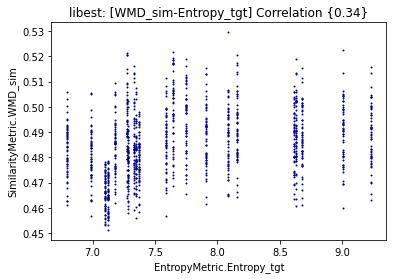

In [ ]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.Entropy_tgt, dist = SimilarityMetric.WMD_sim)

## Composable Manifolds of Entropy and Similarity

Mutual Information - Loss/Noise - WMD Similarity

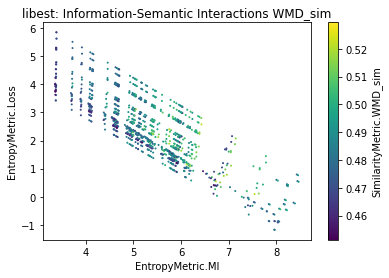

In [ ]:
manifoldEntropy.composable_entropy_plot(
                        manifold_x = EntropyMetric.MI,
                        manifold_y = EntropyMetric.Loss,
                        dist = SimilarityMetric.WMD_sim )

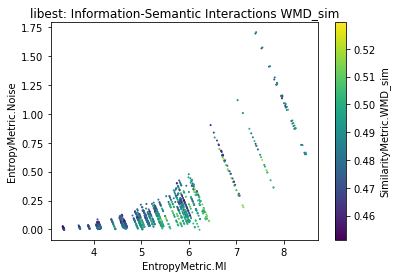

In [ ]:
manifoldEntropy.composable_entropy_plot(
                        manifold_x = EntropyMetric.MI,
                        manifold_y = EntropyMetric.Noise,
                        dist = SimilarityMetric.WMD_sim )

### Grouping Mutual information & Similarity Thru Noise

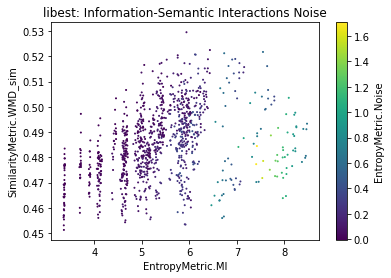

In [ ]:
manifoldEntropy.composable_entropy_plot(
                        manifold_x = EntropyMetric.MI,
                        manifold_y = SimilarityMetric.WMD_sim,
                        dist = EntropyMetric.Noise )

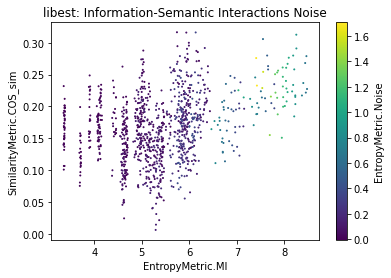

In [ ]:
manifoldEntropy.composable_entropy_plot(
                        manifold_x = EntropyMetric.MI,
                        manifold_y = SimilarityMetric.COS_sim,
                        dist = EntropyMetric.Noise )

### Grouping Mutual information & Similarity Thru Loss

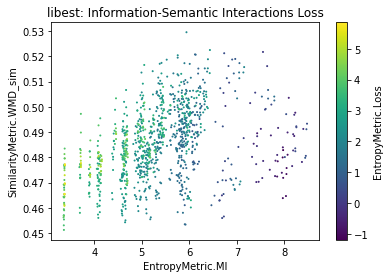

In [ ]:
manifoldEntropy.composable_entropy_plot(
                        manifold_x = EntropyMetric.MI,
                        manifold_y = SimilarityMetric.WMD_sim,
                        dist = EntropyMetric.Loss )

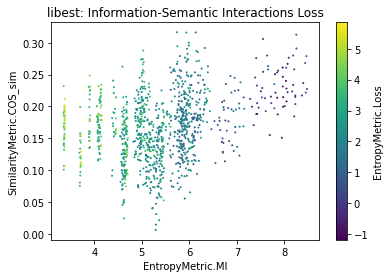

In [ ]:
manifoldEntropy.composable_entropy_plot(
                        manifold_x = EntropyMetric.MI,
                        manifold_y = SimilarityMetric.COS_sim,
                        dist = EntropyMetric.Loss )

### Deployment

In [ ]:
! nbdev_build_docs #<-------- [Activate when stable]

converting: /home/roger/Desktop/ds4se/nbs/6.1_desc.metrics.main.ipynb
converting: /home/roger/Desktop/ds4se/nbs/3.2_mining.unsupervised.mutual_information.traceability.approach.sacp.w2v.ipynb
converting: /home/roger/Desktop/ds4se/nbs/2.6_repr.word2vec.eval.ipynb
An error occurred while executing the following cell:
------------------
# export
# Imports
import pandas as pd
from numpy import mean, std
from statistics import median
from scipy.stats import sem, t
import lizard
import matplotlib.pyplot as plt
from tree_sitter import Language, Parser, Node
#Decoding files
import chardet
from bs4 import UnicodeDammit


# TODO: Remove when mongo call is implemented
import os



from desc_metrics_parser_java import ParserJava

#Not implemented
#from desc_metrics_parser_cpp import ParserCPP
#from desc_metrics_parser_python import ParserPython
------------------

---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most r

An error occurred while executing the following cell:
------------------
from nbdev.showdoc import show_doc
from ds4se.eval.mining.ir.unsupervised.x2v import *
------------------

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<ipython-input-1-96b53471ed64> in <module>
      1 from nbdev.showdoc import show_doc
----> 2 from ds4se.eval.mining.ir.unsupervised.x2v import *

~/Desktop/ds4se/ds4se/eval/mining/ir/unsupervised/x2v.py in <module>
     77 
     78 # Cell
---> 79 class SupervisedVectorEvaluation(VectorEvaluation):
     80 
     81     def __init__(self, params):

~/Desktop/ds4se/ds4se/eval/mining/ir/unsupervised/x2v.py in SupervisedVectorEvaluation()
     98         pass
     99 
--> 100     def vecTypeVerification(self, vecType= VectorizationType.word2vec):
    101         if vecType == VectorizationType.word2vec:
    102             self.sim_list = self.sim_list_w2v

NameEr

In [ ]:
! nbdev_build_lib

Converted 0.0_mgmnt.prep.i.ipynb.
Converted 0.1_mgmnt.prep.conv.ipynb.
Converted 0.3_mgmnt.prep.bpe.ipynb.
Converted 0.6_mgmnt.prep.nltk.ipynb.
Converted 0.7_metrics_module_python.ipynb.
Converted 0.8_metrics_module_java.ipynb.
Converted 0.9_metrics_example.ipynb.
Converted 1.0_exp.i.ipynb.
Converted 1.1_exp.info-[inspect].ipynb.
Converted 1.1_exp.info.ipynb.
Converted 1.2_exp.csnc.ipynb.
Converted 1.2_exp.gen.code.ipynb.
Converted 1.3_exp.csnc_python.ipynb.
Converted 2.0_repr.codebert.ipynb.
Converted 2.0_repr.i.ipynb.
Converted 2.1_repr.codeberta.ipynb.
Converted 2.1_repr.roberta.train.ipynb.
Converted 2.2_repr.roberta.eval.ipynb.
Converted 2.3_repr.word2vec.train.ipynb.
Converted 2.6_repr.word2vec.eval.ipynb.
Converted 2.7_repr.distmetrics.ipynb.
Converted 2.8_repr.sentence_transformers.ipynb.
Converted 3.1_mining.unsupervised.traceability.eda.ipynb.
Converted 3.2_mining.unsupervised.eda.traceability.d2v.ipynb.
No export destination, ignored:
#export
from datetime import datetime
im

Traceback (most recent call last):
  File "/home/roger/.local/bin/nbdev_build_lib", line 8, in <module>
    sys.exit(nbdev_build_lib())
  File "/home/roger/.local/lib/python3.8/site-packages/fastcore/script.py", line 77, in _f
    func(**args.__dict__)
  File "/home/roger/.local/lib/python3.8/site-packages/nbdev/cli.py", line 22, in nbdev_build_lib
    notebook2script(fname=fname)
  File "/home/roger/.local/lib/python3.8/site-packages/nbdev/export.py", line 412, in notebook2script
    for f in sorted(files): d = _notebook2script(f, modules, silent=silent, to_dict=d)
  File "/home/roger/.local/lib/python3.8/site-packages/nbdev/export.py", line 350, in _notebook2script
    if to_dict is None: _add2all(fname_out, [f"'{f}'" for f in names if '.' not in f and len(f) > 0] + extra)
  File "/home/roger/.local/lib/python3.8/site-packages/nbdev/export.py", line 208, in _add2all
    start,end = re_all.start(),re_all.end()
AttributeError: 'NoneType' object has no attribute 'start'


In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 0.0_mgmnt.prep.i.ipynb.
Converted 0.1_mgmnt.prep.conv.ipynb.
Converted 0.3_mgmnt.prep.bpe.ipynb.
Converted 0.6_mgmnt.prep.nltk.ipynb.
Converted 0.7_metrics_module_python.ipynb.
Converted 0.8_metrics_module_java.ipynb.
Converted 0.9_metrics_example.ipynb.
Converted 1.0_exp.i.ipynb.
Converted 1.1_exp.info-[inspect].ipynb.
Converted 1.1_exp.info.ipynb.
Converted 1.2_exp.csnc.ipynb.
Converted 1.2_exp.gen.code.ipynb.
Converted 1.3_exp.csnc_python.ipynb.
Converted 2.0_repr.codebert.ipynb.
Converted 2.0_repr.i.ipynb.
Converted 2.1_repr.codeberta.ipynb.
Converted 2.1_repr.roberta.train.ipynb.
Converted 2.2_repr.roberta.eval.ipynb.
Converted 2.3_repr.word2vec.train.ipynb.
Converted 2.6_repr.word2vec.eval.ipynb.
Converted 2.7_repr.distmetrics.ipynb.
Converted 2.8_repr.sentence_transformers.ipynb.
Converted 3.1_mining.unsupervised.traceability.eda.ipynb.
Converted 3.2_mining.unsupervised.eda.traceability.d2v.ipynb.
No export destination, ignored:
#export
from datetime import datetime
im

AttributeError: 'NoneType' object has no attribute 'start'

In [ ]:
#! pip install -e .

In [ ]:
# Versions of libest_params and VectorEvaluation for export
experiment = 'experiments0.0.x/'
path_data = '../dvc-ds4se/metrics/traceability/' + experiment
def libest_params():
    return{
        "system": 'libest',
        "experiment_path_w2v": path_data + '[libest-VectorizationType.word2vec-LinkType.req2tc-True-1609292406.653621].csv',
        "experiment_path_d2v": path_data + '[libest-VectorizationType.doc2vec-LinkType.req2tc-True-1609289141.142806].csv',
        "corpus" :  "../dvc-ds4se/se-benchmarking/traceability/testbeds/processed/"+ '['+ "libest"  + '-' + "all-corpus" + '-1596063103.098236].csv'
    }
params = libest_params()

In [ ]:
# Versions of libest_params and VectorEvaluation for export
experiment = 'experiments0.0.x/'
path_data = '../dvc-ds4se/metrics/traceability/' + experiment
def libest_params():
    return{
        "system": 'libest',
        "experiment_path_w2v": path_data + '[libest-VectorizationType.word2vec-LinkType.req2tc-True-1609292406.653621].csv',
        "experiment_path_d2v": path_data + '[libest-VectorizationType.doc2vec-LinkType.req2tc-True-1609289141.142806].csv',
        "corpus" :  "../dvc-ds4se/se-benchmarking/traceability/testbeds/processed/"+ '['+ "libest"  + '-' + "all-corpus" + '-1596063103.098236].csv'
    }
params = libest_params()

In [ ]:
#export
class SupervisedVectorEvaluation(VectorEvaluation):

    def __init__(self, params):
        super().__init__(params)
        
        self.sys = params['system']
        
        #Word2vec
        similarities_w2v = self.sim_list_w2v + ['Linked?']
        similarities_w2v = [str(i) for i in similarities_w2v]
        self.df_filtered_w2v = self.df_w2v.copy()
        self.df_filtered_w2v = self.df_filtered_w2v[similarities_w2v] 
        self.df_filtered_w2v = self.df_filtered_w2v[~self.df_filtered_w2v.isin([np.nan, np.inf, -np.inf]).any(1)]
        
        #Doc2vec
        similarities_d2v = self.sim_list_d2v + ['Linked?']
        similarities_d2v = [str(i) for i in similarities_d2v]
        self.df_filtered_d2v = self.df_d2v.copy() 
        self.df_filtered_d2v = self.df_filtered_d2v[similarities_d2v]
        self.df_filtered_d2v = self.df_filtered_d2v[~self.df_filtered_d2v.isin([np.nan, np.inf, -np.inf]).any(1)]
    
    def vecTypeVerification(self, vecType= VectorizationType.word2vec):
        if vecType == VectorizationType.word2vec:
            self.sim_list = self.sim_list_w2v
            y_test = self.df_filtered_w2v['Linked?'].values
            y_score = [self.df_filtered_w2v[ str(sim) ].values for sim in self.sim_list]
            logging.info('Vectorization: ' +  str(vecType) )
        elif vecType == VectorizationType.doc2vec:
            self.sim_list = self.sim_list_d2v
            y_test = self.df_filtered_d2v['Linked?'].values
            y_score = [self.df_filtered_d2v[ str(sim) ].values for sim in self.sim_list]
            logging.info('Vectorization: ' +  str(vecType) )
        return y_test,y_score
    
    def vecTypeVerificationSim(self, vecType= VectorizationType.word2vec,sim=SimilarityMetric.SCM_sim):
        if vecType == VectorizationType.word2vec:
            self.sim_list = self.sim_list_w2v
            y_test = self.df_filtered_w2v['Linked?'].values
            y_score = self.df_filtered_w2v[ str(sim) ].values
            logging.info('Vectorization: ' +  str(vecType) + " " + str(sim))
        elif vecType == VectorizationType.doc2vec:
            self.sim_list = self.sim_list_d2v
            y_test = self.df_filtered_d2v['Linked?'].values
            y_score = self.df_filtered_d2v[ str(sim) ].values
            logging.info('Vectorization: ' +  str(vecType) + " " + str(sim))
        return y_test,y_score
    
    def Compute_precision_recall_gain(self, vecType = VectorizationType.word2vec, sim=SimilarityMetric.SCM_sim):
        '''One might choose PRG if there is little interest in identifying false negatives '''
        y_test,y_score = self.vecTypeVerificationSim(vecType=vecType, sim=sim)    
        
        fig = go.Figure(layout_yaxis_range=[-0.05,1.02],layout_xaxis_range=[-0.05,1.02])
        prg_curve = prg.create_prg_curve(y_test, y_score)
        indices = np.arange(np.argmax(prg_curve['in_unit_square']) - 1,
                        len(prg_curve['in_unit_square']))
        pg = prg_curve['precision_gain']
        rg = prg_curve['recall_gain']
        fig.add_trace(go.Scatter(x=rg[indices], y=pg[indices],
                        line = dict(color="cyan", width=2,dash="solid")))

        indices = np.logical_or(prg_curve['is_crossing'],
                    prg_curve['in_unit_square'])
        fig.add_trace(go.Scatter(x=rg[indices], y=pg[indices],
                    line = dict(color="blue", width=2,dash="solid")))
            
        indices = np.logical_and(prg_curve['in_unit_square'],
                        True - prg_curve['is_crossing'])
        fig.add_trace(go.Scatter(x=rg[indices], y=pg[indices],mode='markers'))
            
        valid_points = np.logical_and( ~ np.isnan(rg), ~ np.isnan(pg))
        upper_hull = prg.convex_hull(zip(rg[valid_points],pg[valid_points]))
        rg_hull, pg_hull = zip(*upper_hull)
        fig.add_trace(go.Scatter(x=rg_hull, y=pg_hull, mode = "lines",
                           line = dict(color="red", width=2,dash="dash")))
        auprg = prg.calc_auprg(prg_curve)
            
        logging.info('auprg:  %.3f' %  auprg)
        logging.info("compute_precision_recall_gain Complete: "+str(sim))
            
        fig.update_layout(
            title=self.sys + "-[" + str(sim) + "]",
            height = 600,
            width = 600,
            xaxis_title='Recall Gain',
            xaxis = dict(
                tickmode = 'linear',
                tick0 = 0,
                dtick = 0.25),
            yaxis_title='Precision Gain',
            yaxis = dict(
                tickmode = 'linear',
                tick0 = 0,
                dtick = 0.25)
            )
        fig.update_yaxes(
            scaleanchor = "x",
            scaleratio = 1,
            )
        
        
        return fig
    
    def Compute_avg_precision(self, vecType = VectorizationType.word2vec):
        '''Generated precision-recall curve enhanced'''
        y_test,y_score = self.vecTypeVerification(vecType=vecType)
        
        linestyles = ['solid','dash','dashdot','dotted']        
        
        color = 'red'
        
        # calculate the no skill line as the proportion of the positive class
        no_skill = len(y_test[y_test==1]) / len(y_test)
        
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=[0, 1], y=[no_skill, no_skill], name='No Skill [{0:0.2f}]'.format(no_skill), mode = "lines",
                         line = dict(color='red', width=.5, dash='dash')))
        
        for count,sim in enumerate(self.sim_list):
            precision, recall, _ = precision_recall_curve(y_test, y_score[count]) #compute precision-recall curve
            average_precision = average_precision_score(y_test, y_score[count])
            auc_score = auc(recall, precision)
            logging.info('Average precision-recall score: {0:0.2f}'.format(average_precision))
            logging.info('Precision-Recall AUC: %.2f' % auc_score)
            
            
            fig.add_trace(go.Scatter(x=recall, y=precision, name=str(sim.name)+' [auc:{0:0.2f}]'.format(auc_score),
                         line = dict(color=color, width=1, dash=linestyles[count])))     
        
        
        
        ##AUC        
        color = 'blue'
        
        fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], name='No Skill', mode = "lines",
                         line = dict(color='blue', width=.5, dash='dot')))
        for count,sim in enumerate(self.sim_list):
            fpr, tpr, _ = roc_curve(y_test, y_score[count]) #compute roc curve
            roc_auc = roc_auc_score(y_test, y_score[count])
            logging.info('ROC AUC %.2f' % roc_auc)
            fig.add_trace(go.Scatter(x=fpr, y=tpr, name=str(sim.name)+' [auc:{0:0.2f}]'.format(roc_auc),
                         line = dict(color=color, width=1, dash=linestyles[count])))
        
    
        fig.update_layout(
            title=self.sys + "-[" + str(vecType) + "]",
            xaxis_title='recall [fpr]',
            yaxis_title='tpr')
        return fig
    
    def Compute_avg_precision_same_plot(self, vecType = VectorizationType.word2vec):
        '''Generated precision-recall curve'''
        
        linestyles = ['solid','dash','dashdot','dotted']        

        fig = go.Figure()
        color = 'red'
        y_test,y_score = self.vecTypeVerification(vecType=vecType)
        
        # calculate the no skill line as the proportion of the positive class
        no_skill = len(y_test[y_test==1]) / len(y_test)
        fig.add_trace(go.Scatter(x=[0, 1], y=[no_skill, no_skill], name='No Skill [{0:0.2f}]'.format(no_skill), mode = "lines",
                         line = dict(color='red', width=.5, dash='dash'))) #reference curve
        
        for count,sim in enumerate(self.sim_list):
            precision, recall, _ = precision_recall_curve(y_test, y_score[count]) #compute precision-recall curve
            average_precision = average_precision_score(y_test, y_score[count])
            auc_score = auc(recall, precision)
            logging.info('Average precision-recall score: {0:0.2f}'.format(average_precision))
            logging.info('Precision-Recall AUC: %.2f' % auc_score)
            
            fig.add_trace(go.Scatter(x=recall, y=precision, name=str(sim.name)+' [auc:{0:0.2f}]'.format(auc_score),
                         line = dict(color=color, width=1, dash=linestyles[count]))) #plot model curve
            
        fig.update_layout(
            title=self.sys + "-[" + str(vecType) + "]",
            xaxis_title='Recall',
            yaxis_title='Precision')
        return fig
    
    def Compute_roc_curve(self, vecType = VectorizationType.word2vec):
        
        linestyles = ['solid','dash','dashdot','dotted']        

        fig = go.Figure()
        color = 'blue'
        y_test,y_score = self.vecTypeVerification(vecType = vecType)

        fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], name='No Skill', mode = "lines",
                         line = dict(color='blue', width=.5, dash='dot'))) #reference curve
        
        for count,sim in enumerate(self.sim_list):
            fpr, tpr, _ = roc_curve(y_test, y_score[count]) #compute roc curve
            roc_auc = roc_auc_score(y_test, y_score[count])
            logging.info('ROC AUC %.2f' % roc_auc)
            
            fig.add_trace(go.Scatter(x=fpr, y=tpr, name=str(sim.name)+' [auc:{0:0.2f}]'.format(roc_auc),
                         line = dict(color=color, width=1, dash=linestyles[count]))) #plot model curve #plot model curve
            
        fig.update_layout(
            title=self.sys + "-[" + str(vecType) + "]",
            xaxis_title='False Positive Rate',
            yaxis_title='True Positive Rate')

        return fig
    
    def CofusionMatrix(self, vecType = VectorizationType.word2vec):
        ##TODO This implementatin is incomplete and not verify it yet
        y_test,y_score = self.vecTypeVerification(vecType=vecType)
        y_score_threshold = [0 if elem<=0.8 else 1 for elem in supevisedEval.y_score] #Hardcoded 0.7 Threshold
        #TODO a Variation threshold analysis
        tn, fp, fn, tp = confusion_matrix(supevisedEval.y_test, y_score_threshold).ravel()
        return tn, fp, fn, tp

In [ ]:
#export
class ManifoldEntropy(VectorEvaluation):
    def __init__(self, params):
        super().__init__(params)
        self.sharedEntropy_filtered = self.sharedInfo.copy()
        self.sharedEntropy_filtered.dropna(inplace=True)
        self.sys = params['system']
    
    def minimum_shared_entropy(self,dist = SimilarityMetric.WMD_sim, extropy=False):
        '''Minimum Shared Plot'''
        ent = EntropyMetric.MSI_I
        color = 'dark blue'
        if extropy:
            ent = EntropyMetric.MSI_X
            color = 'red'
        columns = [str(i) for i in [ent, dist ]]
        
        corr = self.compute_spearman_corr(self.sharedEntropy_filtered, columns)
        logging.info('Correlation {%.2f}' % corr)
        fig = px.scatter(self.sharedEntropy_filtered,
                                 x = columns[0], y = columns[1], color_discrete_sequence=[color])
        fig.update_layout(
            title = self.sys +': ['+ dist.name + '-' + ent.name + '] Correlation {%.2f}' % corr
        )
        return fig
        
    
    def manifold_entropy_plot(self, manifold = EntropyMetric.MI, dist = SimilarityMetric.WMD_sim):
        '''Manifold Entropy'''
        
        columns = [str(i) for i in [manifold, dist]]
        corr = self.compute_spearman_corr(self.manifoldEntropy, columns)
        
        logging.info('Correlation {%.2f}' % corr)
        
        fig = px.scatter(self.manifoldEntropy,
                                 x = columns[0], y = columns[1], color_continuous_scale=["dark blue"])
        fig.update_layout(
            title = self.sys +': ['+ dist.name + '-' + manifold.name + '] Correlation {%.2f}' % corr
        )
        return fig
    
    def composable_entropy_plot(self, 
                                manifold_x = EntropyMetric.MI,
                                manifold_y = EntropyMetric.Loss,
                                dist = SimilarityMetric.WMD_sim,
                                ground = False
                               ):
    
        columns = [str(i) for i in [manifold_x, manifold_y, dist]]
        
        if ground:
            title = params['system']+': Information-Semantic Interactions by GT ' 
        else:
            title = params['system']+': Information-Semantic Interactions '+ dist.name

        
        fig = px.scatter(self.manifoldEntropy,x = columns[0], y = columns[1], color = columns[2], 
                         color_continuous_scale=px.colors.sequential.Viridis)
        fig.update_layout(
            title = title
        )
        return fig
    
    def composable_shared_plot(self, 
                                manifold_x = EntropyMetric.MSI_I,
                                manifold_y = EntropyMetric.Loss,
                                dist = SimilarityMetric.WMD_sim
                               ):
    
        columns = [str(i) for i in [manifold_x, manifold_y, dist]]
        
    
        title = params['system']+': Information-Semantic Interactions '+ dist.name
        
        df = self.df_w2v.dropna(inplace=False)
        print(df.columns)
        fig = px.scatter(df,x = columns[0], y = columns[1], color = columns[2], 
                         color_continuous_scale=px.colors.sequential.Viridis)
        fig.update_layout(
            title = title
        )
        return fig   
    
    def compute_spearman_corr(self, filter_metrics_01, columns):
        df_correlation = filter_metrics_01.copy() 
        correlation = df_correlation[columns].corr(method='spearman')
        #correlation = df_correlation.corr(method='spearman')
        return correlation[columns[0]].values[1]

In [ ]:
manifoldEntropy = ManifoldEntropy(params = params)
manifoldEntropy.composable_shared_plot()

Index(['Source', 'Target', 'DistanceMetric.WMD', 'SimilarityMetric.WMD_sim',
       'DistanceMetric.SCM', 'SimilarityMetric.SCM_sim', 'EntropyMetric.MSI_I',
       'EntropyMetric.MSI_X', 'EntropyMetric.Entropy_src',
       'EntropyMetric.Entropy_tgt', 'EntropyMetric.JI', 'EntropyMetric.MI',
       'EntropyMetric.Loss', 'EntropyMetric.Noise', 'Linked?'],
      dtype='object')
